## Exploratory Data Analysis (EDA)

Before building features, we need to understand our data:
- Distribution of the target variable (churn)
- Key customer characteristics
- Correlations with churn
- Data quality issues

In [0]:
# Load raw data from Unity Catalog
raw_df = spark.table("churn_lab.bronze.churn_raw")

# Display schema and a few sample rows
raw_df.printSchema()
display(raw_df.limit(5))
print(f"Total records = {raw_df.count()}")

root
 |-- customer_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- senior_citizen: integer (nullable = true)
 |-- partner: string (nullable = true)
 |-- dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- phone_service: string (nullable = true)
 |-- multiple_lines: string (nullable = true)
 |-- internet_service: string (nullable = true)
 |-- online_security: string (nullable = true)
 |-- online_backup: string (nullable = true)
 |-- device_protection: string (nullable = true)
 |-- tech_support: string (nullable = true)
 |-- streaming_tv: string (nullable = true)
 |-- streaming_movies: string (nullable = true)
 |-- contract: string (nullable = true)
 |-- paperless_billing: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- monthly_charges: double (nullable = true)
 |-- total_charges: double (nullable = true)
 |-- churn: string (nullable = true)



customer_id gender senior_citizen partner dependents tenure phone_service multiple_lines internet_service online_security online_backup device_protection tech_support streaming_tv streaming_movies contract paperless_billing payment_method monthly_charges total_charges churn 1329-VHWNP Female 0 No No 7 No No phone service DSL No No No No No No Month-to-month No Bank transfer (automatic) 25.05 189.95 No 2984-MIIZL Male 0 No No 4 Yes No Fiber optic No No Yes No No No Month-to-month Yes Bank transfer (automatic) 74.8 321.9 Yes 0266-GMEAO Male 0 Yes Yes 72 Yes Yes Fiber optic Yes Yes Yes Yes Yes Yes Two year Yes Credit card (automatic) 114.3 8058.55 No 5590-YRFJT Female 0 Yes No 20 No No phone service DSL No No No No No No Month-to-month Yes Electronic check 24.45 482.8 Yes 5574-NXZIU Male 0 No No 63 Yes No Fiber optic Yes Yes Yes Yes Yes Yes Two year No Credit card (automatic) 109.2 7049.75 No

Total records = 7043


### Target Variable Distribution

Understanding class balance is critical for churn prediction:
- **Imbalanced classes** require special handling (e.g., class weights, sampling)
- Helps set realistic baseline metrics

In [0]:
# Compute class balance of the target
display(raw_df.groupBy("churn").count())

churn count No 5174 Yes 1869

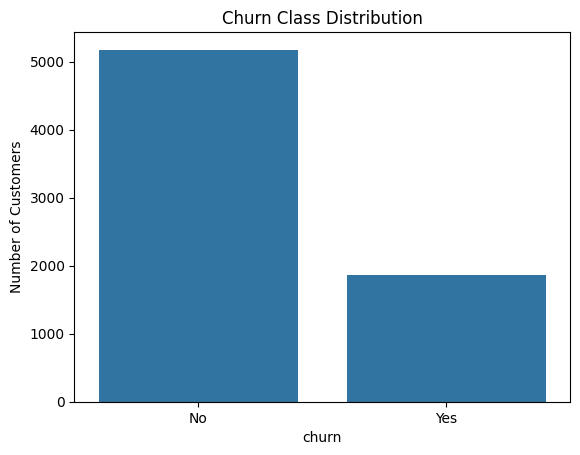

In [0]:
# (Optional) Convert to Pandas for plotting
import seaborn as sns
import matplotlib.pyplot as plt

pdf = raw_df.groupBy("churn").count().toPandas()

sns.barplot(x="churn", y="count", data=pdf)
plt.title("Churn Class Distribution")
plt.ylabel("Number of Customers")
plt.show()

### Distribution of Key Features

Let's examine the distribution of important features that might predict churn.

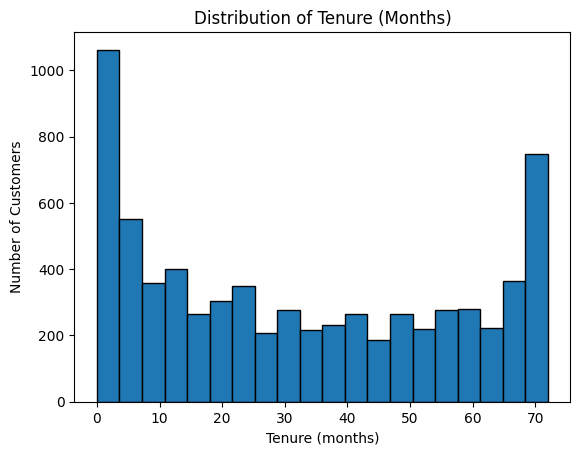

In [0]:
# Histogram of customer tenure
import matplotlib.pyplot as plt
tenure_vals = raw_df.select("tenure").toPandas()
plt.hist(tenure_vals["tenure"], bins=20, edgecolor='black')
plt.title("Distribution of Tenure (Months)")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of Customers")
plt.show()


### Categorical Feature Exploration

Understanding the breakdown of categorical features helps identify potential patterns.

In [0]:
# Count by contract type
display(raw_df.groupBy("contract").count())

# Count by payment method
display(raw_df.groupBy("payment_method").count())


contract count Month-to-month 3875 Two year 1695 One year 1473

payment_method count Bank transfer (automatic) 1544 Credit card (automatic) 1522 Electronic check 2365 Mailed check 1612

In [0]:
display(raw_df.groupBy("senior_citizen").count())
display(raw_df.groupBy("internet_service").count())

senior_citizen count 0 5901 1 1142

internet_service count DSL 2421 Fiber optic 3096 No 1526

### Churn Rate by Segments

Let's see if churn rates differ across customer segments (e.g., contract type).

**Hypothesis**: Month-to-month contracts may have higher churn than long-term contracts.

In [0]:
# Churn rate by contract type
contract_churn = raw_df.groupBy("contract", "churn").count().toPandas()
print(contract_churn)

         contract churn  count
0  Month-to-month    No   2220
1  Month-to-month   Yes   1655
2        Two year    No   1647
3        One year    No   1307
4        One year   Yes    166
5        Two year   Yes     48


In [0]:
import pyspark.sql.functions as F

# Create a DataFrame with numeric columns and churn as 0/1
numeric_df = raw_df.select(
    "tenure", "monthly_charges", "total_charges",
    F.when(F.col("churn")=="Yes", 1).otherwise(0).alias("churn_numeric")
)

# Calculate correlations between churn and each numeric feature
for col in ["tenure", "monthly_charges", "total_charges"]:
    corr_val = numeric_df.stat.corr(col, "churn_numeric")
    print(f"Correlation between {col} and churn: {corr_val:.3f}")


Correlation between tenure and churn: -0.352
Correlation between monthly_charges and churn: 0.193
Correlation between total_charges and churn: -0.198


#### Correlation Matrix Heatmap

A visual representation of how numeric features relate to each other and to churn.

In [0]:
# Correlation matrix for numeric features
numeric_pdf = numeric_df.toPandas()
corr_matrix = numeric_pdf.corr()  # Pandas correlation matrix
print(corr_matrix)

                   tenure  monthly_charges  total_charges  churn_numeric
tenure           1.000000         0.247900       0.825880      -0.352229
monthly_charges  0.247900         1.000000       0.651065       0.193356
total_charges    0.825880         0.651065       1.000000      -0.199484
churn_numeric   -0.352229         0.193356      -0.199484       1.000000


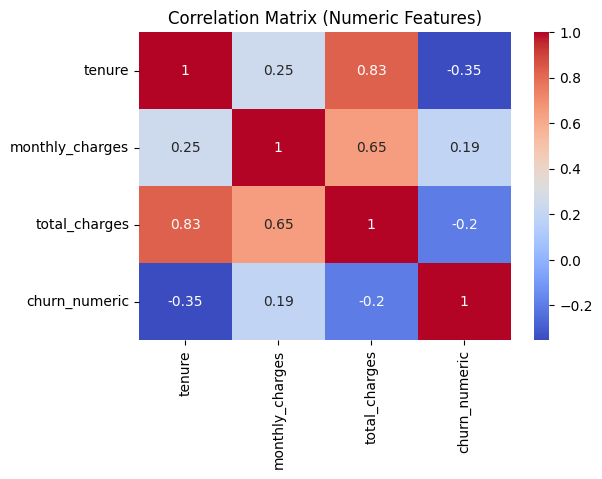

In [0]:
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

### Data Quality Check

**Missing values** can break model training. Let's identify any nulls in our dataset.

In [0]:
# Count missing (null) values in each column
from pyspark.sql.functions import col, sum as spark_sum
missing_counts = raw_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in raw_df.columns])
missing_counts.show()


+-----------+------+--------------+-------+----------+------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------+-----------------+--------------+---------------+-------------+-----+
|customer_id|gender|senior_citizen|partner|dependents|tenure|phone_service|multiple_lines|internet_service|online_security|online_backup|device_protection|tech_support|streaming_tv|streaming_movies|contract|paperless_billing|payment_method|monthly_charges|total_charges|churn|
+-----------+------+--------------+-------+----------+------+-------------+--------------+----------------+---------------+-------------+-----------------+------------+------------+----------------+--------+-----------------+--------------+---------------+-------------+-----+
|          0|     0|             0|      0|         0|     0|            0|             0|               0|              0|            0|                0|           0| 

#### Investigating Null Values

If we found nulls, let's examine those records to understand the pattern.

In [0]:
%sql
select * from churn_lab.bronze.churn_raw where total_charges is null

customer_id gender senior_citizen partner dependents tenure phone_service multiple_lines internet_service online_security online_backup device_protection tech_support streaming_tv streaming_movies contract paperless_billing payment_method monthly_charges total_charges churn 2520-SGTTA Female 0 Yes Yes 0 Yes No No No internet service No internet service No internet service No internet service No internet service No internet service Two year No Mailed check 20.0 null No 2923-ARZLG Male 0 Yes Yes 0 Yes No No No internet service No internet service No internet service No internet service No internet service No internet service One year Yes Mailed check 19.7 null No 4367-NUYAO Male 0 Yes Yes 0 Yes Yes No No internet service No internet service No internet service No internet service No internet service No internet service Two year No Mailed check 25.75 null No 1371-DWPAZ Female 0 Yes Yes 0 No No phone service DSL Yes Yes Yes Yes Yes No Two year No Credit card (automatic) 56.05 null No 4075-WKNIU Female 0 Yes Yes 0 Yes Yes DSL No Yes Yes Yes Yes No Two year No Mailed check 73.35 null No 2775-SEFEE Male 0 No Yes 0 Yes Yes DSL Yes Yes No Yes No No Two year Yes Bank transfer (automatic) 61.9 null No 4472-LVYGI Female 0 Yes Yes 0 No No phone service DSL Yes No Yes Yes Yes No Two year Yes Bank transfer (automatic) 52.55 null No 3115-CZMZD Male 0 No Yes 0 Yes No No No internet service No internet service No internet service No internet service No internet service No internet service Two year No Mailed check 20.25 null No 5709-LVOEQ Female 0 Yes Yes 0 Yes No DSL Yes Yes Yes No Yes Yes Two year No Mailed check 80.85 null No 7644-OMVMY Male 0 Yes Yes 0 Yes No No No internet service No internet service No internet service No internet service No internet service No internet service Two year No Mailed check 19.85 null No 3213-VVOLG Male 0 Yes Yes 0 Yes Yes No No internet service No internet service No internet service No internet service No internet service No internet service Two year No Mailed check 25.35 null No

### Key EDA Findings (Summary)

Based on this analysis, we can expect:
1. **Class Imbalance**: Churn is likely the minority class → use `scale_pos_weight` in XGBoost
2. **Contract Type**: Month-to-month contracts likely have higher churn rates
3. **Tenure**: Negative correlation with churn (longer customers = more loyal)
4. **Monthly Charges**: May have positive correlation with churn (higher cost = more likely to leave)
5. **Missing Data**: Any nulls in `total_charges` need to be handled in feature engineering

**Next Steps**: Clean the data and engineer features in the Silver → Gold layers.